# RoboGarden Machine Learning Capstone Project: Facial Recognition
***

This dataset is a processed version of the YouTube Faces Dataset, that contained short videos of celebrities that are publicly available and downloaded from YouTube. There are multiple videos of each celebrity (up to 6 videos per celebrity). The original videos were cropped around the faces and only 240 consecutive frames were kept for each original video. 
The dataset is available here: https://www.kaggle.com/selfishgene/youtube-faces-with-facial-keypoints

This is the **1st of 3 Notebooks** containing a comparison of possible models built to perform facial recognition of the facial landmarks provided in teh dataset.

**Notebook 1: YouTubeFacialRecognition.ipynb**  
    - Contains all the mothods used on the subset data (youtube_faces_with_keypoints_small.csv) provided on Kaggle)
**Notebook 2: YouTubeFacialRecognitionBig.ipynb** 
    - Contains clustering and classification methods on the full dataset (youtube_faces_with_keypoints_large.csv)
**Notebook 3: YouTubeFacialRecognitionBig-ANNs.ipynb** 
    - Contains roughly optimized neural networks on both the 2D and 3D landmarks

Supporting documents: 
- two .csv files containing the full list and a subset list of the file names and number of frames for each video file
- the corresponding .npz files containing the rgb color image frame, the bouding box and 2D and 3D landmark coordinates
- my stacked cleverly named 'export_dataframe.csv' file with each frame given a line in the table with the name of the person, the frame number and label encoding, to save you some time!
- a model final model for a small dataset (best_modelsmall7.h5) and a model for the large dataset (best_model_3D4.h5)
- a word document and powerpoint (YouTube celebrity facial recognition.pptx) that highlight the process and results

References:
Lior Wolf, Tal Hassner and Itay Maoz 
Face Recognition in Unconstrained Videos with Matched Background Similarity. 
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR), 2011. (pdf)

2D and 3D keypoints, from the following paper: 
<br>Adrian Bulat and Georgios Tzimiropoulos. 
How far are we from solving the 2D & 3D Face Alignment problem? 
(and a dataset of 230,000 3D facial landmarks), arxiv, 2017. (pdf)

## Import Libraries

In [29]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import glob
from sklearn import cluster
import seaborn as sns

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import itertools

#early stopping plugin
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Load the data set: 

In [30]:
videoDF = pd.read_csv('youtube_faces_with_keypoints_small.csv')
videoDF.head(5)

videoID     personName  imageHeight  imageWidth  videoDuration  \
0  Alison_Lohman_0  Alison_Lohman        228.0       213.0          240.0   
1  Alison_Lohman_1  Alison_Lohman        248.0       201.0           79.0   
2  Alison_Lohman_2  Alison_Lohman        335.0       308.0          136.0   
3  Alison_Lohman_3  Alison_Lohman        151.0       110.0           53.0   
4  Alison_Lohman_4  Alison_Lohman        236.0       228.0          147.0   

   averageFaceSize  numVideosForPerson  
0        90.150000                 6.0  
1       108.417722                 6.0  
2       122.161765                 6.0  
3        58.000000                 6.0  
4        91.680272                 6.0

In [31]:
videoDF.describe()

imageHeight  imageWidth  videoDuration  averageFaceSize  \
count   139.000000  139.000000     139.000000       139.000000   
mean    210.424460  192.064748     130.776978        92.895535   
std      60.848229   58.195100      73.706138        33.179382   
min      81.000000   79.000000      43.000000        40.431579   
25%     167.000000  150.500000      65.000000        68.843519   
50%     203.000000  189.000000     111.000000        88.496063   
75%     241.000000  227.500000     217.000000       109.871662   
max     369.000000  372.000000     240.000000       230.744681   

       numVideosForPerson  
count          139.000000  
mean             5.172662  
std              0.379322  
min              5.000000  
25%              5.000000  
50%              5.000000  
75%              5.000000  
max              6.000000

## Dataset Overview:

In [32]:
#Count the number of still images
videoDF.videoDuration.sum()

18178.0

In [33]:
#Number of unique people
categories = len(videoDF.personName.unique())
nameList = videoDF.personName.unique()
numList = np.arange(0,27)
print("There are", categories, 'unique people in the dataset')
print(nameList)
print(numList),print(len(numList))

There are 27 unique people in the dataset
['Alison_Lohman' 'Kevin_Spacey' 'Lauren_Hutton' 'Robert_F_Kennedy_Jr'
 'Amanda_Beard' 'Andrew_Bernard' 'Barbara_Brezigar' 'Daniel_Kurtzer'
 'Elizabeth_Berkeley' 'Fred_Eckhard' 'George_W_Bush' 'Kim_Gandy'
 'Maria_Bello' 'Mary_Matalin' 'Narendra_Modi' 'Newt_Gingrich'
 'Nicanor_Duarte_Frutos' 'Norm_Macdonald' 'Paul_Bremer' 'Paul_Celluci'
 'Phil_Gramm' 'Ray_Romano' 'Richard_Rodriguez' 'Richard_Shelby'
 'Robert_Nardelli' 'Tara_VanDerveer' 'Tavis_Smiley']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
27


(None, None)

In [34]:
# Number of people in dataset
groupedByPerson = videoDF.groupby("personName")
numVidsPerPerson = groupedByPerson.count()['videoID']
groupedByPerson.count().sort_values('videoID', axis=0, ascending=False)

videoID  imageHeight  imageWidth  videoDuration  \
personName                                                               
Alison_Lohman                6            6           6              6   
Robert_F_Kennedy_Jr          6            6           6              6   
Kevin_Spacey                 6            6           6              6   
Lauren_Hutton                6            6           6              6   
Nicanor_Duarte_Frutos        5            5           5              5   
Tara_VanDerveer              5            5           5              5   
Robert_Nardelli              5            5           5              5   
Richard_Shelby               5            5           5              5   
Richard_Rodriguez            5            5           5              5   
Ray_Romano                   5            5           5              5   
Phil_Gramm                   5            5           5              5   
Paul_Celluci                 5            5           5              5   
Paul_Bremer                  5            5           5              5   
Norm_Macdonald               5            5           5              5   
Narendra_Modi                5            5           5              5   
Newt_Gingrich                5            5           5              5   
Amanda_Beard                 5            5           5              5   
Mary_Matalin                 5            5           5              5   
Maria_Bello                  5            5           5              5   
Kim_Gandy                    5            5           5              5   
George_W_Bush                5            5           5              5   
Fred_Eckhard                 5            5           5              5   
Elizabeth_Berkeley           5            5           5              5   
Daniel_Kurtzer               5            5           5              5   
Barbara_Brezigar             5            5           5              5   
Andrew_Bernard               5            5           5              5   
Tavis_Smiley                 5            5           5              5   

                       averageFaceSize  numVideosForPerson  
personName                                                  
Alison_Lohman                        6                   6  
Robert_F_Kennedy_Jr                  6                   6  
Kevin_Spacey                         6                   6  
Lauren_Hutton                        6                   6  
Nicanor_Duarte_Frutos                5                   5  
Tara_VanDerveer                      5                   5  
Robert_Nardelli                      5                   5  
Richard_Shelby                       5                   5  
Richard_Rodriguez                    5                   5  
Ray_Romano                           5                   5  
Phil_Gramm                           5                   5  
Paul_Celluci                         5                   5  
Paul_Bremer                          5                   5  
Norm_Macdonald                       5                   5  
Narendra_Modi                        5                   5  
Newt_Gingrich                        5                   5  
Amanda_Beard                         5                   5  
Mary_Matalin                         5                   5  
Maria_Bello                          5                   5  
Kim_Gandy                            5                   5  
George_W_Bush                        5                   5  
Fred_Eckhard                         5                   5  
Elizabeth_Berkeley                   5                   5  
Daniel_Kurtzer                       5                   5  
Barbara_Brezigar                     5                   5  
Andrew_Bernard                       5                   5  
Tavis_Smiley                         5                   5

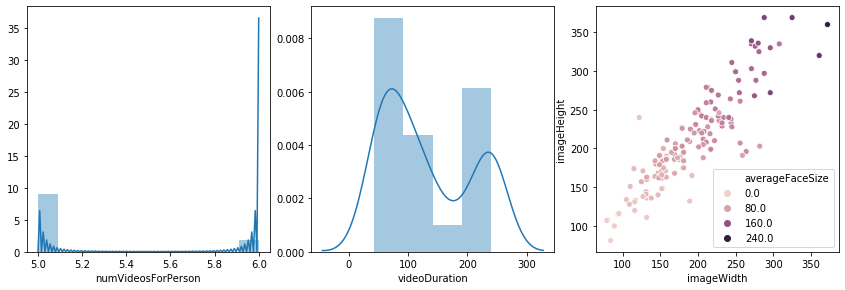

In [35]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(12, 4)
f.tight_layout()


sns.distplot(videoDF['numVideosForPerson'],  ax=axes[0])

sns.distplot(videoDF["videoDuration"],  ax=axes[1])

sns.scatterplot(y="imageHeight", x= "imageWidth", 
                data=videoDF, hue = 'averageFaceSize', legend = 'brief',ax=axes[2])

## Locate the Video Files for Use

Glob is an extension of Python that assigns a filepath to each file in a given directory so that it can be called by the program.

In [36]:
npzFilesFullPath = glob.glob('*.npz')

#Full file path extension that doesn't work for me...
#npzFilesFullPath = glob.glob('C:/Users/woodl/OneDrive/Documents/RoboGarden/Final Project/YouTube Faces/faces*/*.npz')

In [37]:
#npzFilesFullPath

In [38]:
# remove the .npz file extension
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]

In [39]:
#videoIDs

In [40]:
# create a dictionary to call the videos, key is the file name in teh dataframe, value is the filepath
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

In [41]:
#fullPaths

In [42]:
np.random.seed(3)
numVideos = 4
framesToShowFromVideo = np.array([0.1,0.5,0.9])
numFramesPerVideo = len(framesToShowFromVideo)

In [43]:
# define which points need to be connected with a line
jawPoints          = [ 0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

In [44]:
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index,size=numVideos,replace=False),'videoID']
print(randVideoIDs)

15            Lauren_Hutton_3
86    Nicanor_Duarte_Frutos_2
6              Kevin_Spacey_0
3             Alison_Lohman_3
Name: videoID, dtype: object


## Display still frames from the videos
adapted from the original kernal https://www.kaggle.com/selfishgene/exploring-youtube-faces-with-keypoints-dataset

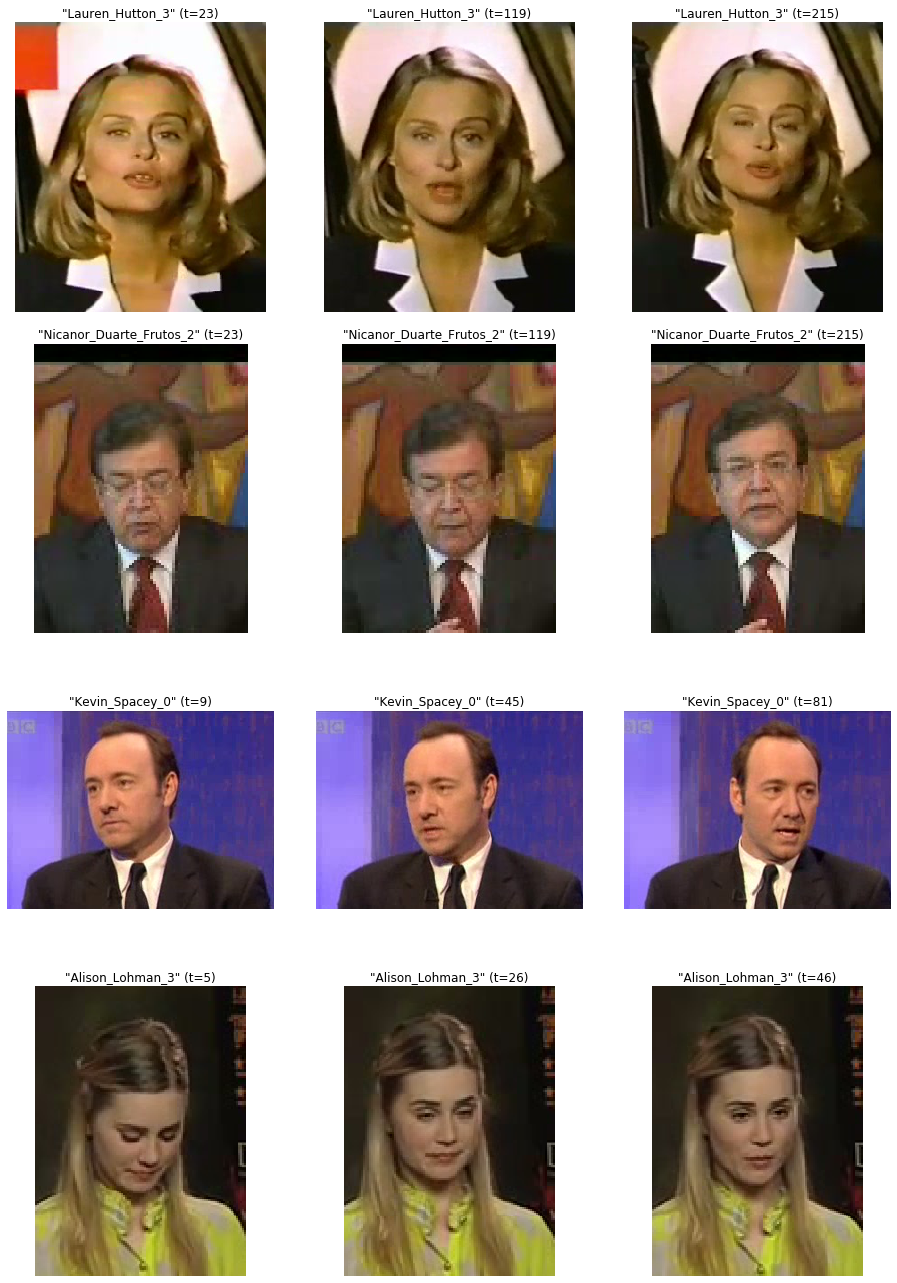

In [45]:
fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(13,18))
fig.tight_layout()

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axArray[i][j].imshow(colorImages[:,:,:,frameInd])
        axArray[i][j].set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        axArray[i][j].set_axis_off()


## Add the 2D facial recognition markers

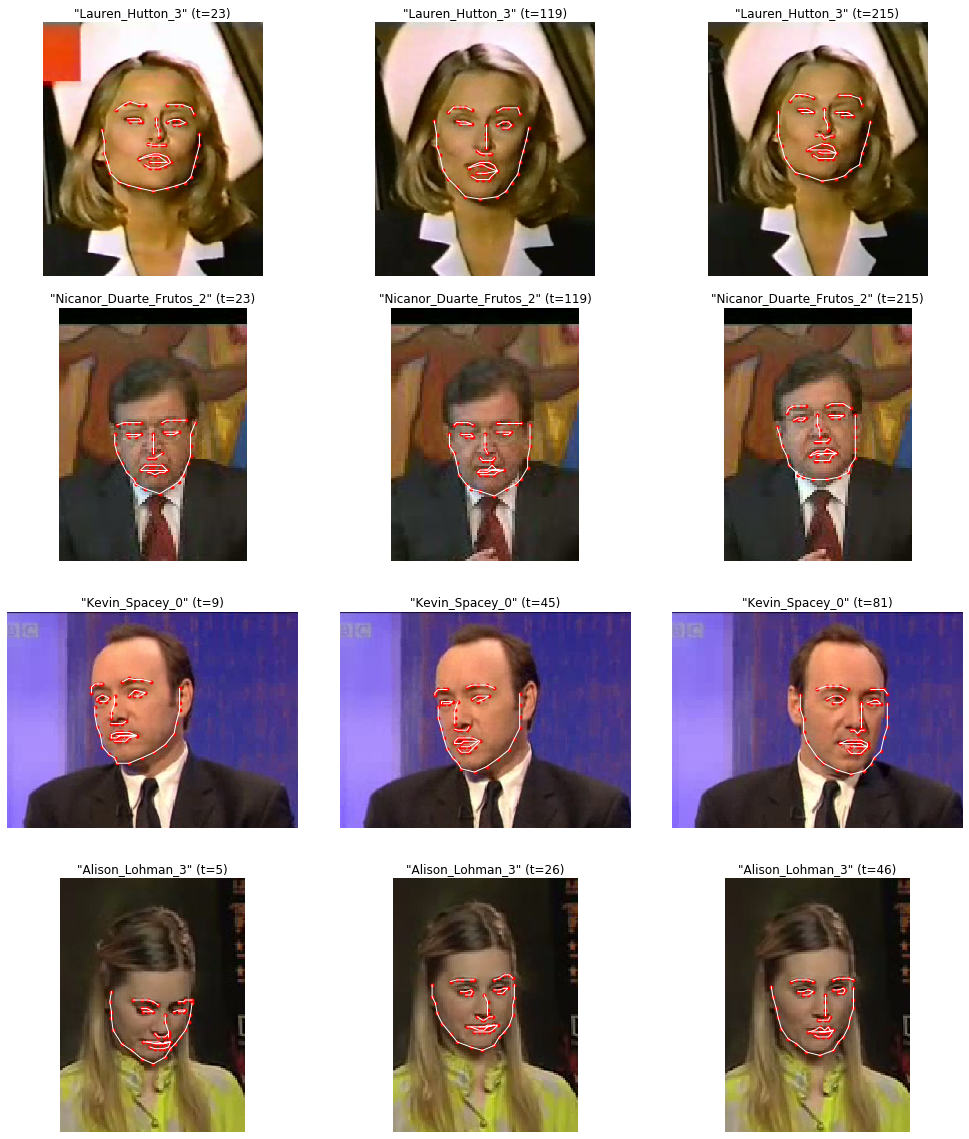

In [46]:
fig, axArray = plt.subplots(nrows=numVideos,ncols=numFramesPerVideo,figsize=(14,16))
fig.tight_layout()

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content with the landmark points
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axArray[i][j].imshow(colorImages[:,:,:,frameInd])
        axArray[i][j].scatter(x=landmarks2D[:,0,frameInd],y=landmarks2D[:,1,frameInd],s=9,c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks2D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks2D[conPts[0]:conPts[-1],1,frameInd]
            axArray[i][j].plot(xPts,yPts,c='w',lw=1)
        axArray[i][j].set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        axArray[i][j].set_axis_off()

## This package also allows you to view the facial recognition markers in 3D

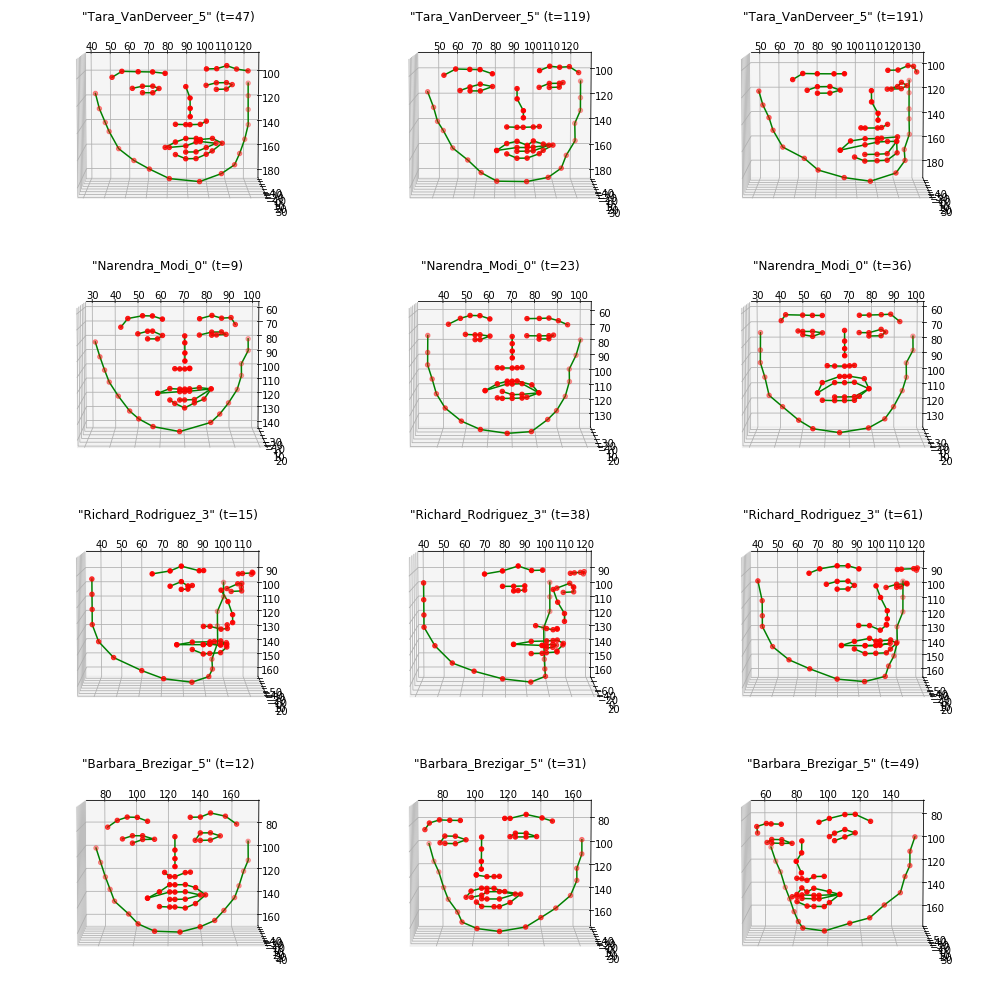

In [47]:
# ,stratify=y, as argument in train_test_split
# show several 3D keypoints
numVideos = 4
framesToShowFromVideo = np.array([0.2,0.5,0.8])
numFramesPerVideo = len(framesToShowFromVideo)

# select a random subset of 'numVideos' from the available videos
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index,size=numVideos,replace=False),'videoID']

fig = plt.figure(figsize=(14,14))
for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages']
    boundingBox = videoFile['boundingBox']
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content
    selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        subplotInd = i*numFramesPerVideo + j+1
        ax = fig.add_subplot(numVideos, numFramesPerVideo, subplotInd, projection='3d')
        ax.scatter(landmarks3D[:,0,frameInd], landmarks3D[:,1,frameInd], landmarks3D[:,2,frameInd],c='r')
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks3D[conPts[0]:conPts[-1],0,frameInd]
            yPts = landmarks3D[conPts[0]:conPts[-1],1,frameInd]
            zPts = landmarks3D[conPts[0]:conPts[-1],2,frameInd]
            ax.plot3D(xPts,yPts,zPts,color='g')         
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.view_init(elev=96, azim=90)
        ax.set_title('"%s" (t=%d)' %(videoID,frameInd), fontsize=12)
        
plt.tight_layout()

## Initiate Exploratory Data Analysis on the landmark points to compare images

Collect all of the 2D and 3D shapes from all frames from all videos and save to a single numpy array matrix

In [48]:
totalNumberOfFrames = int(videoDF['videoDuration'].sum())
print('Total number of frames in dataset: ',totalNumberOfFrames)

#Initialize arrarys for the landmark points for each frame in the dataset
landmarks2D_all = np.zeros((68,2,int(totalNumberOfFrames)))
landmarks3D_all = np.zeros((68,3,int(totalNumberOfFrames)))

#print(landmarks2D_all.shape)
#print(landmarks3D_all.shape)


shapeIndToVideoID = {} # dictionary for later useage
endInd = 0

# Add the frames to the arrays
for i, videoID in enumerate(videoDF['videoID']):
    
    # load video
    videoFile = np.load(fullPaths[videoID])
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']
    
    startInd = endInd
    endInd   = startInd + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,startInd:endInd] = landmarks2D
    landmarks3D_all[:,:,startInd:endInd] = landmarks3D
    
    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(startInd,endInd)):
        shapeIndToVideoID[shapeInd] = (videoID, videoFrameInd)
    

Total number of frames in dataset:  18178


## Normalize the landmarks so they can be compared

In [49]:
# center the shapes around zero
# i.e. such that for each frame the mean x,y,z coordinates will be zero
# or in math terms: Xc = X - mean(X), Yc = Y - mean(Y), Zc = Z - mean(Z)
landmarks2D_centered = np.zeros(landmarks2D_all.shape)
landmarks2D_centered = landmarks2D_all - np.tile(landmarks2D_all.mean(axis=0),[68,1,1])

landmarks3D_centered = np.zeros(landmarks3D_all.shape)
landmarks3D_centered = landmarks3D_all - np.tile(landmarks3D_all.mean(axis=0),[68,1,1])

# normalize the shapes such that they have the same scale
# i.e. such that for each frame the mean euclidian distance from the shape center will be one
# or in math terms: mean( sqrt(dX^2 + dY^2 + dZ^2) ) = 1 
landmarks2D_normlized = np.zeros(landmarks2D_all.shape)
landmarks2D_normlized = landmarks2D_centered / np.tile(np.sqrt((landmarks2D_centered**2).sum(axis=1)).mean(axis=0), [68,2,1])

landmarks3D_normlized = np.zeros(landmarks3D_all.shape)
landmarks3D_normlized = landmarks3D_centered / np.tile(np.sqrt((landmarks3D_centered**2).sum(axis=1)).mean(axis=0), [68,3,1])

## Visualize the normalizations

Text(0.5, 1.0, 'Normlized Shapes')

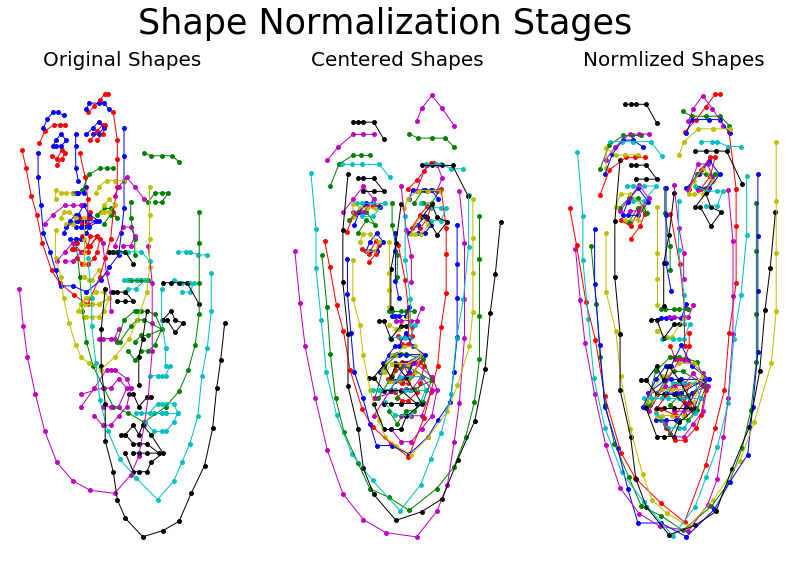

In [50]:
#%% check the 2D normalization and verify that everything is as expected
# select random several frames to be used as test cases
np.random.seed(2)

listOfShapeColors = ['r','g','b','m','y','c','k']
numShapesToPresent = len(listOfShapeColors)
listOfShapeInds = np.random.choice(range(int(totalNumberOfFrames)),size=numShapesToPresent,replace=False)

#plt.close('all') (not sure what this line is for, closes the plot windows, I suppose if you have in a different IDE)

plt.figure(figsize=(14,9))
plt.suptitle('Shape Normalization Stages',fontsize=35) # main figure box setup and title

plt.subplot(1,3,1)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_all[:,0,shapeInd], -landmarks2D_all[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_all[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_all[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); 
plt.title('Original Shapes', fontsize=20)

plt.subplot(1,3,2)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_centered[:,0,shapeInd], -landmarks2D_centered[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_centered[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_centered[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Centered Shapes', fontsize=20)

plt.subplot(1,3,3)
for k,shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_normlized[:,0,shapeInd], -landmarks2D_normlized[:,1,shapeInd], s=15, c=listOfShapeColors[k])
    for conPts in listOfAllConnectedPoints:
        xPts =  landmarks2D_normlized[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_normlized[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts,yPts,c=listOfShapeColors[k],lw=1)
plt.axis('off'); plt.title('Normlized Shapes', fontsize=20)

## Perform Cluster Analysis 
We are going to use the landmarked points on each of the still frames for each video to create clusters of similar faces.

In [51]:
# Check the shape of our input array
landmarks2D_normlized.shape

(68, 2, 18178)

In [52]:
#%% cluster normalized shapes and show the cluster centers
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T
#print(normalizedShapesTable)

Save the scores of each model as we increase the number of clusters to find the optimum number of groups

In [53]:
scores = []

for numClusters in range(1, 35):
    shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
    clusterAssignment = shapesModel.predict(normalizedShapesTable)
    scores.append(shapesModel.inertia_)
       

Plot the scores to utilize the "Elbow Method" to locate the optimum 

Text(0, 0.5, 'SSE')

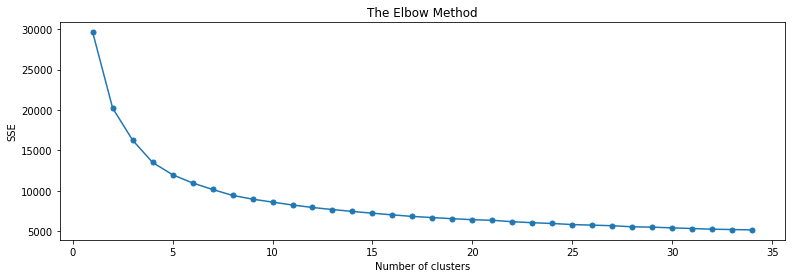

In [54]:
plt.figure(figsize=(13, 4))
plt.plot(range(1, 35), scores, marker='.', markersize=10)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE') 

This analysis is interesting because it suggests that the optimum number of clusters is around 6. But we have 27 unique people in the dataset.  

What's going on?  Let's take a look at the clusters:

In [199]:
# run the model for the preferred number of clusters

numClusters = 8
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T

shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
clusterAssignment = shapesModel.predict(normalizedShapesTable)

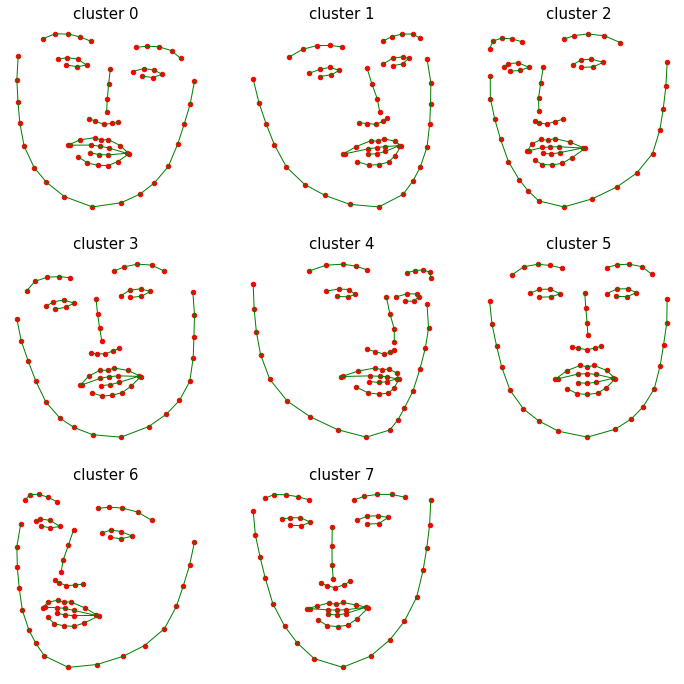

In [200]:
plt.figure(figsize=(12,12))
numRowsAndCols = int(np.ceil(np.sqrt(numClusters)))
for i in range(numClusters):
    plt.subplot(numRowsAndCols,numRowsAndCols,i+1);
    currClusterShape = np.reshape(shapesModel.cluster_centers_[i,:], [68,2])
    plt.scatter(x=currClusterShape[:,0],y=-currClusterShape[:,1],s=20,c='r')
    for conPts in listOfAllConnectedPoints:
        xPts =  currClusterShape[conPts[0]:conPts[-1],0]
        yPts = -currClusterShape[conPts[0]:conPts[-1],1]
        plt.plot(xPts,yPts,c='g',lw=1)
    plt.title('cluster %d' %(i),fontsize=15)
    plt.axis('off')

[  478   488   489 ... 17723 17727 17729]


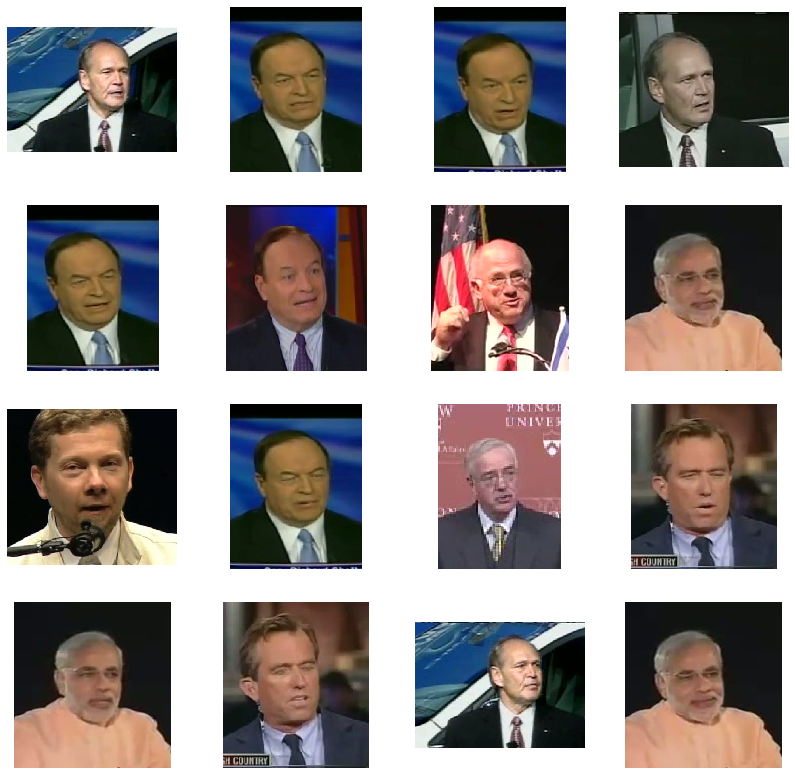

In [201]:
#Cluster 1: Crooked mount and Look Right

#%% show several original images that are assigned to a particular cluster
selectedCluster = 1
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
print(shapeIndsAssignedToCluster)
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

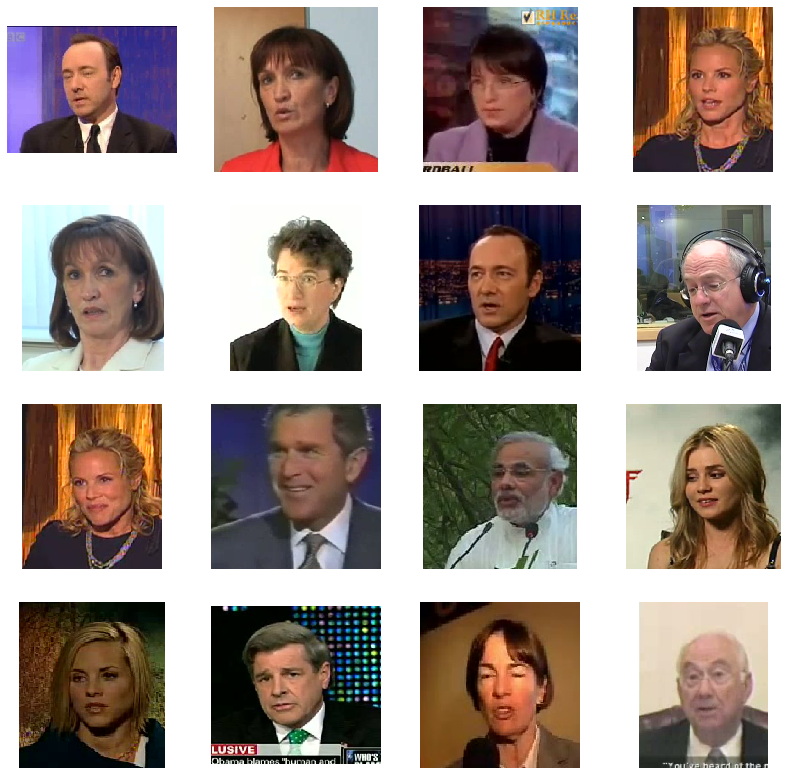

In [202]:
#Cluster 2: Look left

#%% show several original images that are assigned to a particular cluster
selectedCluster = 2
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

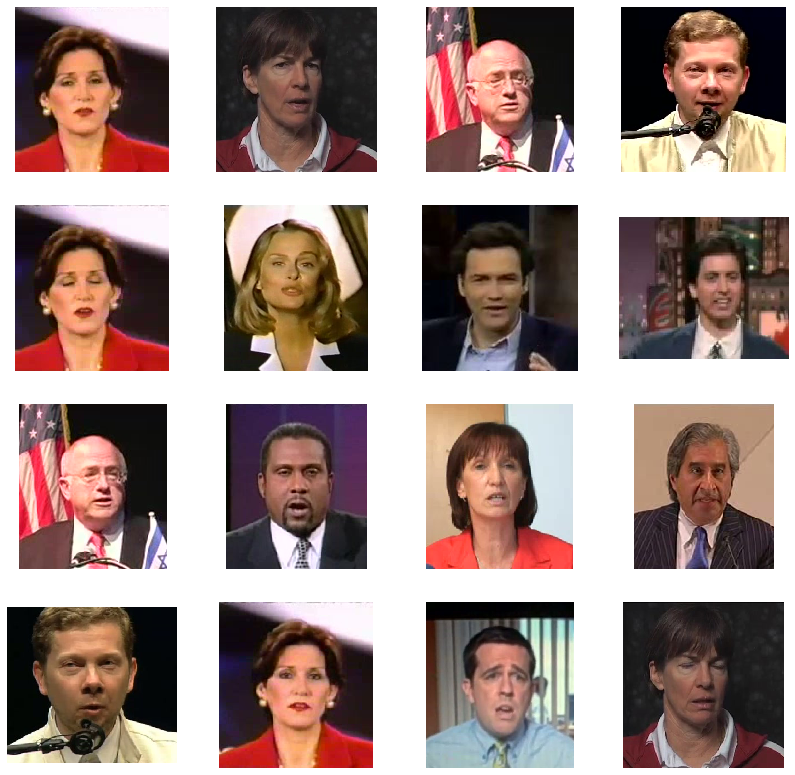

In [203]:
#Cluster 5: Look straight ahead
selectedCluster = 5
numRows = 4; numCols = 4;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(14,14))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

## So great, we can cluster the faces into groups with certain facial expressions or looking into specific directions.  But can we group them by the same person?

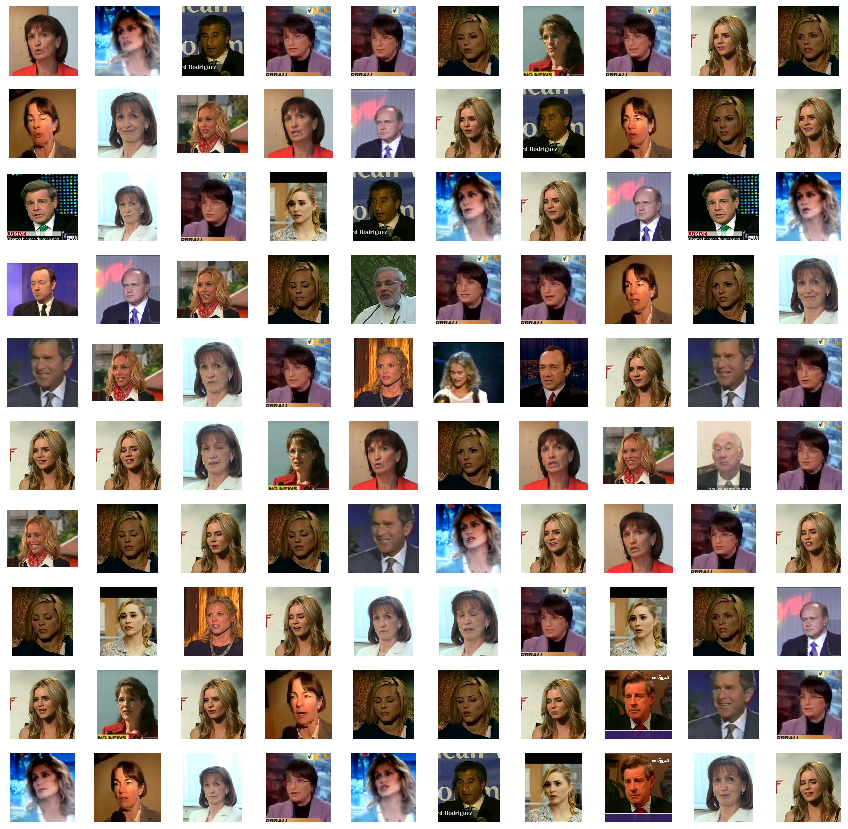

In [204]:
# run the model for the preferred number of clusters
numClusters = 27
normalizedShapesTable = np.reshape(landmarks2D_normlized, [68*2, landmarks2D_normlized.shape[2]]).T

shapesModel = cluster.KMeans(n_clusters=numClusters, n_init=5, random_state=1).fit(normalizedShapesTable[::2,:])
clusterAssignment = shapesModel.predict(normalizedShapesTable)

selectedCluster = 19
numRows = 10; numCols = 10;

shapeIndsAssignedToCluster = np.nonzero(clusterAssignment == selectedCluster)[0]
listOfShapeInds = np.random.choice(shapeIndsAssignedToCluster ,size=numRows*numCols,replace=False)

plt.figure(figsize=(15,15))
for i, shapeInd in enumerate(listOfShapeInds):
    # load video and pickout the relevent frame
    videoID  = shapeIndToVideoID[shapeInd][0]
    frameInd = shapeIndToVideoID[shapeInd][1]    
    videoFile = np.load(fullPaths[videoID])
    image = videoFile['colorImages'][:,:,:,frameInd]
    
    # show the image
    plt.subplot(numRows,numCols,i+1);
    plt.imshow(image); plt.axis('off')

## Create a dataframe to store actual and predicted labels based on the images or masking

In [205]:
# Clustering grouping
predict = pd.Series(clusterAssignment)

In [206]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(videoDF['personName'])
videoDF['person']=le.transform(videoDF['personName']) 

personList = videoDF.person.unique()

In [207]:
videoDF.head(3)

videoID     personName  imageHeight  imageWidth  videoDuration  \
0  Alison_Lohman_0  Alison_Lohman        228.0       213.0          240.0   
1  Alison_Lohman_1  Alison_Lohman        248.0       201.0           79.0   
2  Alison_Lohman_2  Alison_Lohman        335.0       308.0          136.0   

   averageFaceSize  numVideosForPerson  person  
0        90.150000                 6.0       0  
1       108.417722                 6.0       0  
2       122.161765                 6.0       0

In [208]:
# Get original label
dfCompare=[]
dfCompare =  pd.DataFrame(columns = ['videoIDexpanded','frameNum','actualName'])

In [209]:
start = 0
numRows = len(videoDF.index)
#print(numRows)

for row in range(0,numRows): 
    frames = int(videoDF['videoDuration'][row])
    person_encode = int((videoDF['person'][row]))
    ID = (videoDF['videoID'][row])
    #print(frames, person_encode)
    
    for individual_frame in range(0,frames):
        #print(individual_frame,person_encode) 
        dfCompare.at[start+individual_frame,'actualName'] = person_encode
        dfCompare.at[start+individual_frame,'videoIDexpanded'] = ID
        dfCompare.at[start+individual_frame,'frameNum'] = int(individual_frame)
        
    start = start + frames
    #print('new start = ', start)

In [210]:
dfCompare['predictedName'] = predict
dfCompare[235:245]

videoIDexpanded frameNum actualName  predictedName
235  Alison_Lohman_0      235          0             19
236  Alison_Lohman_0      236          0             19
237  Alison_Lohman_0      237          0             19
238  Alison_Lohman_0      238          0             19
239  Alison_Lohman_0      239          0             19
240  Alison_Lohman_1        0          0             18
241  Alison_Lohman_1        1          0             19
242  Alison_Lohman_1        2          0             18
243  Alison_Lohman_1        3          0             18
244  Alison_Lohman_1        4          0             18

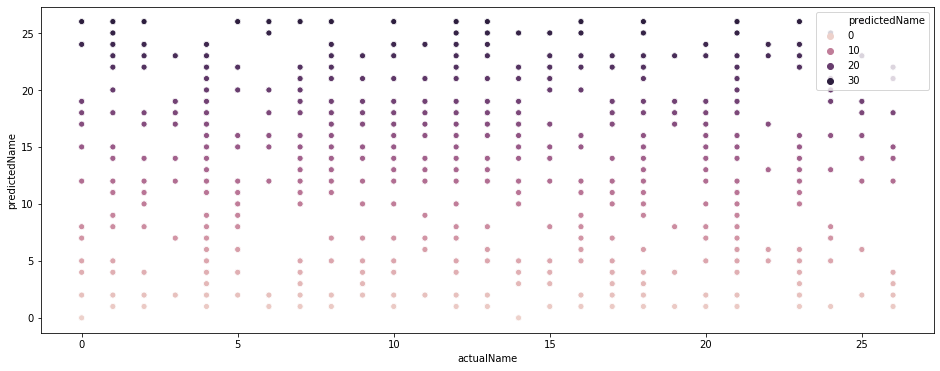

In [211]:
plt.figure(figsize=(16, 6))
sns.scatterplot(dfCompare['actualName'],dfCompare['predictedName'],hue=dfCompare["predictedName"])

## Let's see what some of these clusters look like

In [212]:
# Get the user to pick a person
who =  int(input("Enter an integer between 0 and 26 ") )

# Get the row numbers for all actual chosen person
index = dfCompare.loc[dfCompare['actualName'] == who].index

#Grab the maximum for making the range
indexMax = max(index)

#Create an empty dataframe for holding the data to make a pie for each person of the prediction breakdowns
dfPie = pd.DataFrame(columns = ['singlePredict'])

Enter an integer between 0 and 26 17


In [213]:
for i in range(0,indexMax):
    dfPie.at[i,'singlePredict'] = dfCompare['predictedName'][i]  

In [214]:
# Find the most common group for images belonging to teh same chosen group
predPerson = dfPie['singlePredict'].value_counts().keys().tolist()
count = dfPie['singlePredict'].value_counts().tolist()
mostCommon = predPerson[who]
print(predPerson)
print(count)
print(mostCommon)

[19, 18, 4, 2, 12, 1, 15, 14, 23, 22, 16, 26, 5, 10, 6, 8, 21, 17, 7, 24, 11, 20, 25, 9, 13, 3, 0]
[934, 797, 732, 730, 717, 710, 706, 632, 609, 567, 536, 527, 511, 439, 424, 416, 378, 357, 341, 337, 325, 302, 299, 293, 262, 174, 116]
17


In [215]:
numPredictionsForPerson = len(dfPie)

In [216]:
percent = []

for z in range (0,len(count)):
        accuracyCluster = round((count[z]/numPredictionsForPerson)*100,1)
        percent.append(accuracyCluster)
        
print(percent)        

[7.1, 6.1, 5.6, 5.5, 5.4, 5.4, 5.4, 4.8, 4.6, 4.3, 4.1, 4.0, 3.9, 3.3, 3.2, 3.2, 2.9, 2.7, 2.6, 2.6, 2.5, 2.3, 2.3, 2.2, 2.0, 1.3, 0.9]


# Pie plot representing the number of different faces for a known series of frames specific to one person
plt.figure(figsize=(10, 6))
plt.title('Percentage of Predicted People')
figPie = plt.pie(percent,labels =predPerson)



With 7 % accuracy.


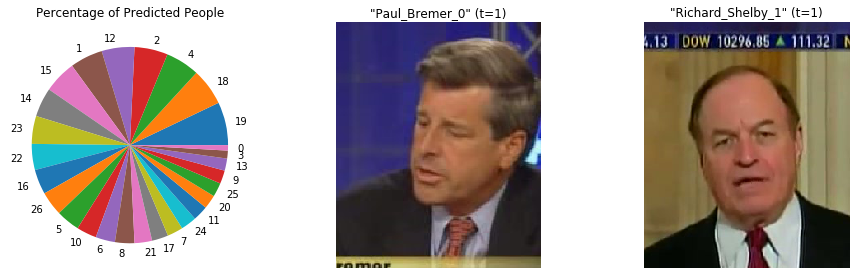

In [225]:
#Grab the most common person from the list (first position)

#Create a figure from the pie chart, then a frame from the known person and a frame from the most common predicted match 
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
fig.tight_layout()

accuracyCluster = (count[0]/numPredictionsForPerson)

new = round((count[0]/numPredictionsForPerson)*100)
print('With',new,'% accuracy.')
ax1.pie(percent,labels =predPerson)
ax1.set_title('Percentage of Predicted People', fontsize=12)


#Show image from the labelled group 0
yyy = videoDF.loc[videoDF['person'] == who]
videoID = yyy['videoID'].values[0]
videoFile = np.load(fullPaths[videoID])
colorImages = videoFile['colorImages'] # arrays of the image colour values
framesToShowFromVideo = 1
selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)) #.astype(int)
ax2.imshow(colorImages[:,:,:,selectedFrames])
ax2.set_title('"%s" (t=%d)' %(videoID,framesToShowFromVideo), fontsize=12)
ax2.set_axis_off()


# pick an image from all those labelled as the most common group and see if you get the right person 

# Show image from the most popular group in the cluster (maybe it will match?)    
zzz = dfCompare.loc[dfCompare['predictedName'] == mostCommon]

numBelongingToChosenClass = zzz.videoIDexpanded.count()

originalPerson = zzz['actualName'].value_counts().keys().tolist()
countOrig = zzz['actualName'].value_counts().tolist()
mostCommonOrig = originalPerson[0]

# grab just the rows in a dataframe of the most common originally properly labelled person
zz2 = zzz.loc[dfCompare['actualName'] == mostCommonOrig]


# get the filename for the represented person
videoID2 = zz2['videoIDexpanded'].values[who]
#get the frame number for that labelling
frameID2 = 1 

videoFile = np.load(fullPaths[videoID2])
colorImages = videoFile['colorImages'] # arrays of the image colour values

framesToShowFromVideo = frameID2
selectedFrames = (framesToShowFromVideo*(colorImages.shape[3]-1)) #.astype(int)

ax3.imshow(colorImages[:,:,:,selectedFrames])
ax3.set_title('"%s" (t=%d)' %(videoID2,framesToShowFromVideo), fontsize=12)
ax3.set_axis_off() 

So, in this case, the clustering algorithm did not properly match the people. 

## So what's next? How about a neural network?

Our dataset in this case is the set or=f normalized 2D landmark sets

In [74]:
from keras.models import Sequential
from keras.layers import Dropout, Dense 

In [75]:
X = normalizedShapesTable

In [76]:
X.shape

(18178, 136)

Our target is the labelled person for each still frame in the videos and we need to encode the categories.  
No further scaling is required, it has already been scaled.

In [77]:
y=pd.get_dummies(dfCompare['actualName']).values
print(y)


[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [79]:
print(X_train.shape)
print(X_test.shape)

(13633, 136)
(4545, 136)


## Set-up a neural network model.  

In [55]:
#Create a new neural network
model = Sequential()

input_layer = Dense(units=136, activation='relu', kernel_initializer='uniform')
model.add(input_layer)

hidden_layer = Dense(units=80, activation='relu', kernel_initializer='uniform')
model.add(hidden_layer)

hidden_layer = Dense(units=40, activation='relu', kernel_initializer='uniform')
model.add(hidden_layer)

output_layer = Dense(units=categories, activation='softmax', kernel_initializer='uniform')
model.add(output_layer)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


## We can visualize the progress and accuracy of the model with LiveLossPlot

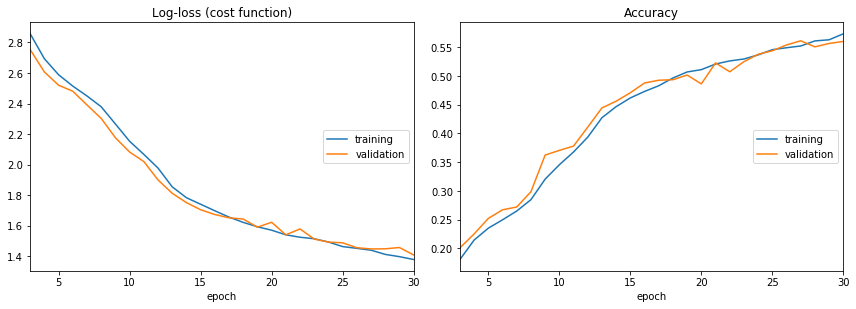

Log-loss (cost function):
training   (min:    1.377, max:    3.182, cur:    1.377)
validation (min:    1.407, max:    3.086, cur:    1.407)

Accuracy:
training   (min:    0.092, max:    0.573, cur:    0.573)
validation (min:    0.128, max:    0.561, cur:    0.560)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 136)               18632     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                10960     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1107      
Total params: 33,939
Trainable params: 33,939
Non-trainable params: 0
_________________________________________________________________


In [56]:
from livelossplot import PlotLossesKeras

model.fit(X_train, y_train,
          batch_size = 100,
          epochs = 30,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)
model.summary()

In [57]:
# The ??
y_pred=[]
y_pred = model.predict(X_test).round(3)


In [58]:
#labelled with the person encoding (integers)
yPred=[]
yPred=pd.DataFrame(y_pred,columns=[personList])

#Labelled with the actual name
#yPred=pd.DataFrame(y_pred,columns=[nameList])

for row in range(0,len(X_test)):
    maxY = max(y_pred[row,:]).round(3)
    #print(y_pred[row,:],maxY)
    for column in range(0,27):      
        
        if yPred.ix[row,column] == maxY:
            yPred.at[row,column]= 1
        else:
            yPred.at[row,column]=0
            
y_test=pd.DataFrame(y_test)

In [59]:
yPred.head()

0    8    10   23   1    2    3    4    5    6  ...    16   17   18   19  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0  0.0   

    20   21   22   24   25   26  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 27 columns]

In [60]:
cm = confusion_matrix(yPred.values.argmax(axis=1), y_test.values.argmax(axis=1))
#print(classification_report(y_test,yPred))

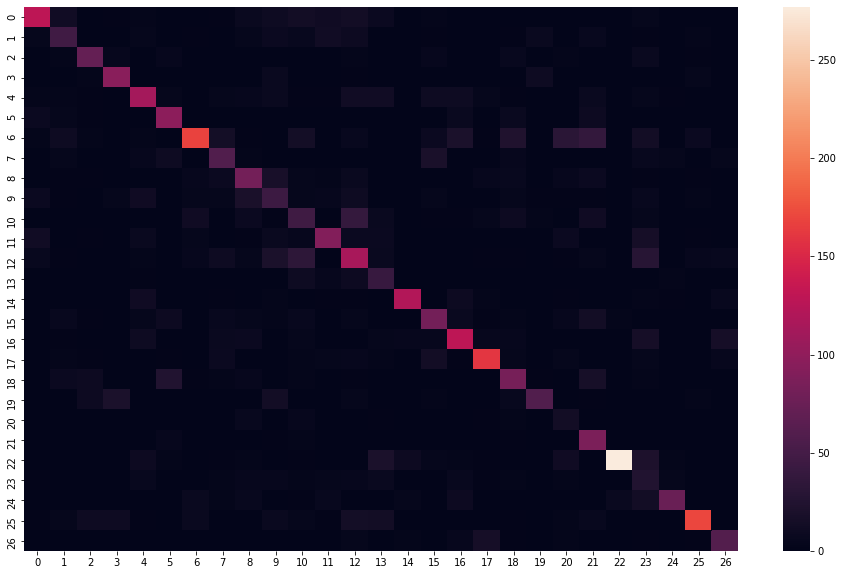

In [61]:
plt.figure(figsize=(16, 10))
sns.heatmap(cm)

In [161]:
### Need to figure out the proper way to show the accuracy for a multilabel classification ###

#need the original y_test in a column with the grade groups

#accuracy=accuracy_score(y_test, yPred)
#print(accuracy)

## Now that I have a basic working NN, let's start to play and optimize

In [197]:
model2 = Sequential()

model2.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer
model2.add(Dropout(rate=0.1))
model2.add(Dense(units=160, activation='relu', kernel_initializer='uniform'))
model2.add(Dropout(rate=0.1))
model2.add(Dense(units=160, activation='relu', kernel_initializer='uniform')) 
model2.add(Dropout(rate=0.1))
model2.add(Dense(units=60, activation='relu', kernel_initializer='uniform')) 
model2.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


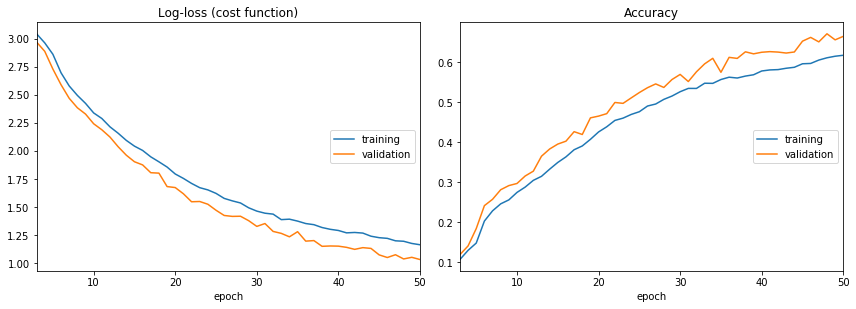

Log-loss (cost function):
training   (min:    1.161, max:    3.259, cur:    1.161)
validation (min:    1.030, max:    3.224, cur:    1.030)

Accuracy:
training   (min:    0.057, max:    0.618, cur:    0.618)
validation (min:    0.065, max:    0.671, cur:    0.665)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 136)               18632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 136)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 160)               21920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 160)               25760     
_________

In [198]:
model2.fit(X_train, y_train,
          batch_size = 200,
          epochs = 50,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

model2.summary()
y_pred2 = model2.predict(X_test).round(2)

In [199]:
loss, accuracy = model2.evaluate(X_test,y_test)
loss =loss.round(2)
accuracy = accuracy.round(2)
print(loss),print(accuracy)

4545/4545 [==============================] - 0s 38us/step
1.03
0.66


(None, None)

## Model 3

In [209]:
model3 = Sequential()

model3.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer
model3.add(Dropout(rate=0.1))
model3.add(Dense(units=100, activation='relu', kernel_initializer='uniform'))
model3.add(Dropout(rate=0.1))
model3.add(Dense(units=120, activation='relu', kernel_initializer='uniform')) 
model3.add(Dense(units=40, activation='relu', kernel_initializer='uniform')) 
model3.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

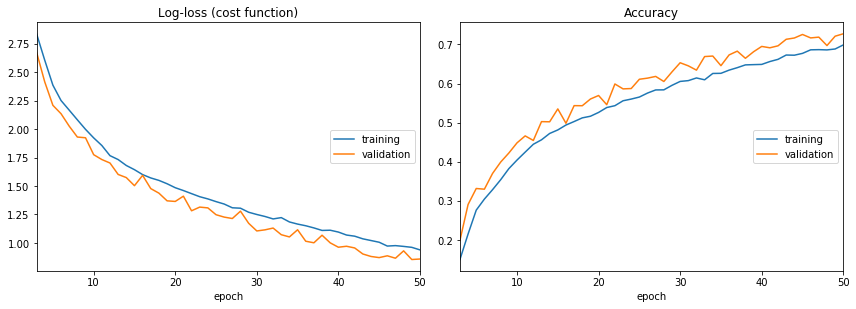

Log-loss (cost function):
training   (min:    0.939, max:    3.203, cur:    0.939)
validation (min:    0.854, max:    3.081, cur:    0.858)

Accuracy:
training   (min:    0.075, max:    0.699, cur:    0.699)
validation (min:    0.109, max:    0.727, cur:    0.727)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 136)               18632     
_________________________________________________________________
dropout_25 (Dropout)         (None, 136)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 100)               13700     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 120)               12120     
_________

In [210]:
model3.fit(X_train, y_train,
          batch_size = 50,
          epochs = 50,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

model3.summary()
y_pred3 = model3.predict(X_test).round(2)

In [212]:
loss, accuracy = model3.evaluate(X_test,y_test)
loss =loss.round(2)
accuracy = accuracy.round(2)
print(loss),print(accuracy)

4545/4545 [==============================] - 0s 46us/step
0.86
0.73


(None, None)

## Model 4

In [213]:
model4 = Sequential()

model4.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer
model4.add(Dropout(rate=0.1))
model4.add(Dense(units=100, activation='relu', kernel_initializer='uniform'))
model4.add(Dropout(rate=0.1))
model4.add(Dense(units=120, activation='relu', kernel_initializer='uniform')) 
model4.add(Dense(units=40, activation='relu', kernel_initializer='uniform')) 
model4.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

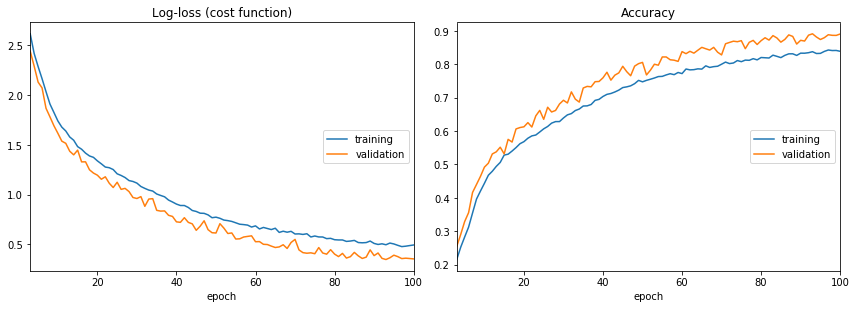

Log-loss (cost function):
training   (min:    0.478, max:    3.185, cur:    0.494)
validation (min:    0.348, max:    3.078, cur:    0.355)

Accuracy:
training   (min:    0.075, max:    0.843, cur:    0.839)
validation (min:    0.091, max:    0.892, cur:    0.891)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 136)               18632     
_________________________________________________________________
dropout_27 (Dropout)         (None, 136)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 100)               13700     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 120)               12120     
_________

(None, None)

In [214]:
model4.fit(X_train, y_train,
          batch_size = 20,
          epochs = 100,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

model4.summary()
y_pred4 = model4.predict(X_test).round(2)

loss, accuracy = model4.evaluate(X_test,y_test)
loss =loss.round(2)
accuracy = accuracy.round(2)
print(loss),print(accuracy)

## Model 5

In [217]:
model5 = Sequential()

model5.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer
model5.add(Dense(units=100, activation='relu', kernel_initializer='uniform'))
model5.add(Dropout(rate=0.05))
model5.add(Dense(units=120, activation='relu', kernel_initializer='uniform')) 
model5.add(Dense(units=40, activation='relu', kernel_initializer='uniform')) 
model5.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

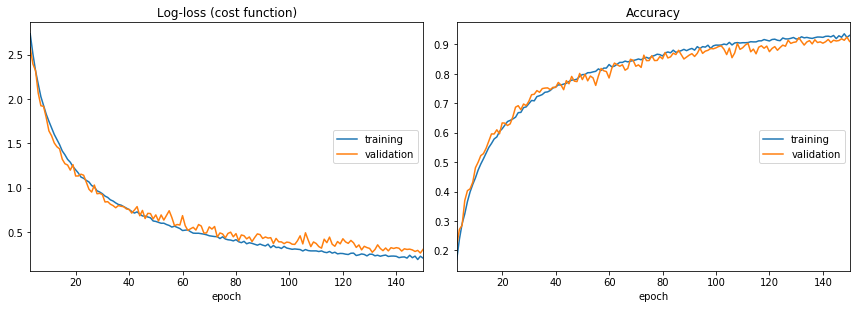

Log-loss (cost function):
training   (min:    0.191, max:    3.173, cur:    0.206)
validation (min:    0.264, max:    3.081, cur:    0.305)

Accuracy:
training   (min:    0.084, max:    0.936, cur:    0.931)
validation (min:    0.090, max:    0.925, cur:    0.910)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 136)               18632     
_________________________________________________________________
dense_113 (Dense)            (None, 100)               13700     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 120)               12120     
_________________________________________________________________
dense_115 (Dense)            (None, 40)                4840      
_________

(None, None)

In [218]:
model5.fit(X_train, y_train,
          batch_size = 20,
          epochs = 150,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

model5.summary()

In [251]:
y_pred5 = model5.predict(X_test).round(2)

loss, accuracy = model5.evaluate(X_test,y_test)
loss =loss.round(2)
accuracy = accuracy.round(2)
print(loss),print(accuracy)

4545/4545 [==============================] - 0s 61us/step
0.3
0.91


(None, None)

91% Accuracy, pretty happy about that.  But what does it mean? Did it group it by person, or direction the face is moving?
<br>Model does not appear to be overfit either.

## Let's take a look at the confusion matrix and stats

Reference for image plot: https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

This code also uses the 'itertools' package to plot the numbers onto the matrix. (https://docs.python.org/2/library/itertools.html)


In [259]:
y_pred5DF = pd.DataFrame(y_pred5) # convert the output array into a dataframe
y_pred5DF.head()

0    1    2    3    4    5    6    7    8    9  ...    17   18   19   20  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

    21   22   23   24   25   26  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 27 columns]

In [260]:
y_test.head()

0   1   2   3   4   5   6   7   8   9  ...  17  18  19  20  21  22  23  24  \
0   0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   0   
4   0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   

   25  26  
0   0   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0  

[5 rows x 27 columns]

In [352]:
CM5  = confusion_matrix(y_pred5DF.values.argmax(axis=1), y_test.values.argmax(axis=1))

In [84]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


#Make the matrix
np.set_printoptions(precision=2)


In [ ]:

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(CM5, classes = nameList,
                      title='Confusion matrix, without normalization')

## Let's calculate the evaluators of the model

Reference code: https://www.python-course.eu/confusion_matrix.php

In [90]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [344]:
print("label precision recall")
for label in range(27):
    print(f"{label:5d} {precision(label, CM5):9.3f} {recall(label, CM5):6.3f}")

label precision recall
    0     0.951  0.852
    1     0.798  0.919
    2     0.893  0.939
    3     0.920  0.969
    4     0.930  0.853
    5     0.919  0.937
    6     0.982  0.920
    7     0.877  0.890
    8     0.914  0.874
    9     0.747  0.874
   10     0.791  0.915
   11     0.902  0.841
   12     0.833  0.888
   13     0.891  0.911
   14     0.965  0.979
   15     0.850  0.928
   16     0.976  0.932
   17     0.991  0.901
   18     0.809  0.919
   19     0.976  0.976
   20     0.830  0.790
   21     0.972  0.916
   22     0.993  0.976
   23     0.925  0.864
   24     0.938  0.929
   25     0.937  0.965
   26     0.960  0.931


In [346]:
print("precision total:", precision_macro_average(CM5))
print("recall total:", recall_macro_average(CM5))

precision total: 0.9062965066956657
recall total: 0.9107891304074249


In [365]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [349]:
accuracy(CM5)

0.9102310231023102

## Model 6

In [367]:
model6 = Sequential()

model6.add(Dense(units=136, activation='relu', kernel_initializer='uniform')) #input layer

model6.add(Dense(units=100, activation='relu', kernel_initializer='uniform'))
model6.add(Dropout(rate=0.05))
model6.add(Dense(units=120, activation='relu', kernel_initializer='uniform')) 
model6.add(Dense(units=40, activation='relu', kernel_initializer='uniform'))
model6.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

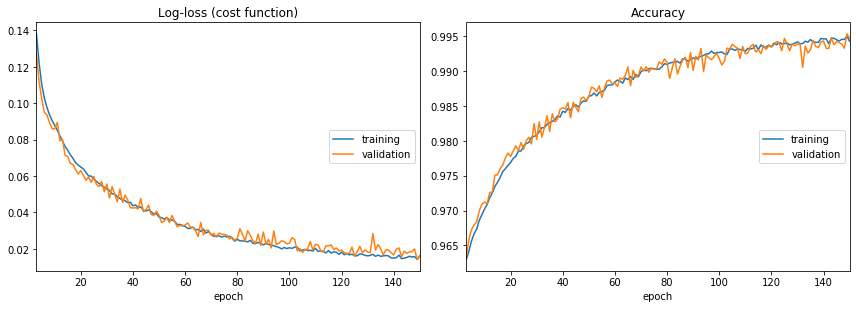

Log-loss (cost function):
training   (min:    0.014, max:    0.153, cur:    0.016)
validation (min:    0.014, max:    0.149, cur:    0.016)

Accuracy:
training   (min:    0.963, max:    0.995, cur:    0.994)
validation (min:    0.963, max:    0.995, cur:    0.995)


In [368]:
model6.fit(X_train, y_train,
          batch_size = 20,
          epochs = 150,
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

In [357]:
y_pred6 = model6.predict(X_test).round(2)

loss6, accuracy6 = model6.evaluate(X_test,y_test)
loss6 =loss6.round(3)
accuracy6 = accuracy6.round(3)
print(loss6),print(accuracy6)

y_pred6DF = pd.DataFrame(y_pred6) # convert the output array into a dataframe
y_pred6DF.head()

cm6  = confusion_matrix(y_pred6DF.values.argmax(axis=1), y_test.values.argmax(axis=1))

4545/4545 [==============================] - 0s 65us/step
0.02
0.99


Confusion matrix, without normalization


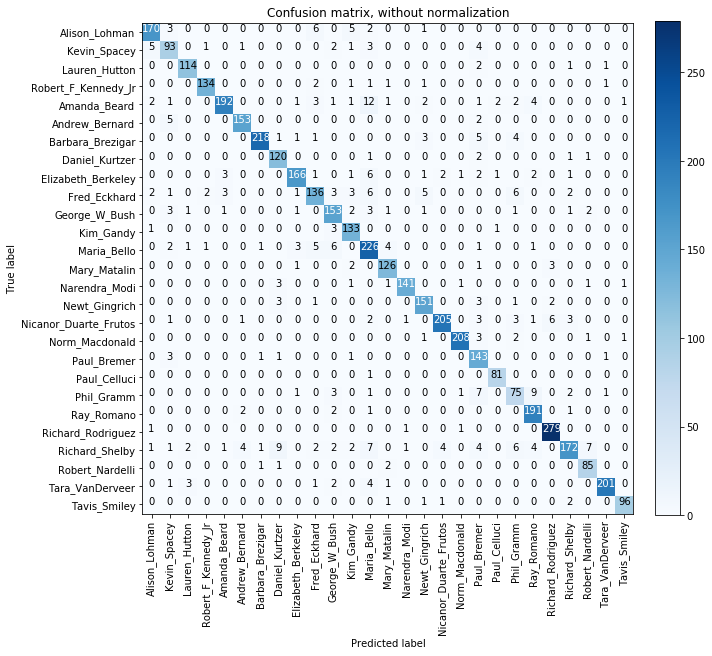

In [358]:
#Make the matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm6, classes = nameList,
                      title='Confusion matrix, without normalization')

In [359]:
print("label precision recall")
for label in range(27):
    print(f"{label:5d} {precision(label, cm6):9.3f} {recall(label, cm6):6.3f}")

label precision recall
    0     0.934  0.909
    1     0.816  0.845
    2     0.942  0.966
    3     0.971  0.950
    4     0.960  0.850
    5     0.950  0.956
    6     0.982  0.936
    7     0.870  0.960
    8     0.949  0.888
    9     0.861  0.800
   10     0.864  0.900
   11     0.869  0.964
   12     0.819  0.900
   13     0.913  0.947
   14     0.979  0.946
   15     0.904  0.938
   16     0.967  0.907
   17     0.981  0.963
   18     0.781  0.953
   19     0.953  0.988
   20     0.750  0.750
   21     0.901  0.970
   22     0.962  0.989
   23     0.925  0.748
   24     0.876  0.955
   25     0.980  0.944
   26     0.970  0.950


In [363]:
print("precision total:", precision_macro_average(cm6))
print("recall total:", recall_macro_average(cm6))

precision total: 0.9122159124528232
recall total: 0.917518109577594


In [409]:
f1 = (2*precision_macro_average(cm6)*recall_macro_average(cm6))/(precision_macro_average(cm6) + recall_macro_average(cm6))
print("F1 Score {:0.2f}".format(f1))

F1 Score 0.91


## Can the accuracy be improved by using the 3D Landmark Masking?

In [90]:
normalizedShapesTable3D = np.reshape(landmarks3D_normlized, [68*3, landmarks3D_normlized.shape[2]]).T

In [91]:
X3D = normalizedShapesTable3D

# y will remain the same

In [92]:
X3D.shape

(18178, 204)

In [93]:
X3d_train, X3d_test, y_train, y_test = train_test_split(X3D, y, test_size=0.25, random_state=0)
y_test=pd.DataFrame(y_test)

In [94]:
print(X3d_train.shape)
print(X3d_test.shape)

(13633, 204)
(4545, 204)


In [103]:
model7 = Sequential()

model7.add(Dense(units=204, activation='relu', kernel_initializer='uniform')) #input layer
model7.add(Dropout(rate=0.15))
model7.add(Dense(units=150, activation='relu', kernel_initializer='uniform'))
model7.add(Dense(units=80, activation='relu', kernel_initializer='uniform')) 
model7.add(Dense(units=30, activation='relu', kernel_initializer='uniform'))
model7.add(Dense(units=categories, activation='softmax', kernel_initializer='uniform')) #output layer

model7.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

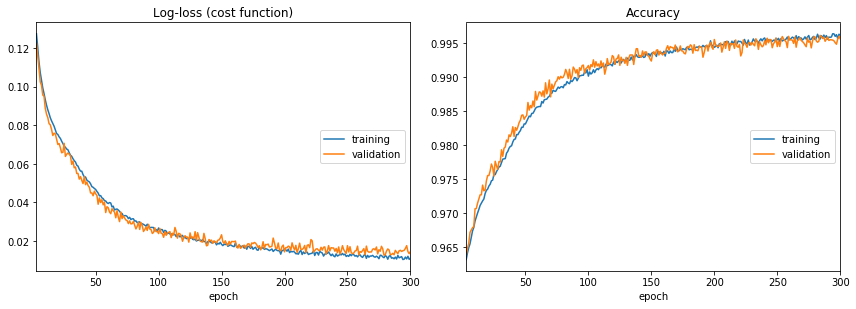

Log-loss (cost function):
training   (min:    0.010, max:    0.151, cur:    0.011)
validation (min:    0.013, max:    0.143, cur:    0.015)

Accuracy:
training   (min:    0.963, max:    0.996, cur:    0.996)
validation (min:    0.963, max:    0.996, cur:    0.996)

Epoch 00300: val_acc did not improve from 0.99614


In [104]:
#Add early stopping into this model so it doesn't run forever
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)
mc = ModelCheckpoint('best_modelsmall7.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model7.fit(X3d_train, y_train,
          batch_size = 25,
          epochs = 300,
          validation_data=(X3d_test, y_test),
          callbacks=[PlotLossesKeras(),es,mc],
          verbose=1)

In [233]:
saved_model = load_model('best_modelsmall7.h5')

y_pred7 = saved_model.predict(X3d_test).round(2)
#y_pred7 = model7.predict(X3d_test).round(2)

loss7, accuracy7 = saved_model.evaluate(X3d_test,y_test)
loss7 =loss7.round(2)
accuracy7 = accuracy7.round(3)
print(loss7),print(accuracy7)

4545/4545 [==============================] - 0s 81us/step
0.01
0.996


(None, None)

In [235]:
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 204)               41820     
_________________________________________________________________
dropout_6 (Dropout)          (None, 204)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 150)               30750     
_________________________________________________________________
dense_35 (Dense)             (None, 80)                12080     
_________________________________________________________________
dense_36 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_37 (Dense)             (None, 27)                837       
Total params: 87,917
Trainable params: 87,917
Non-trainable params: 0
_________________________________________________________________


In [236]:
# build an image of the neural network
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from ann_visualizer.visualize import ann_viz
ann_viz(saved_model, filename = 'Small YouTube Facial recognition Neural Network', title="YouTube Facial Recognition 3D Landmark Neural Network")

In [106]:
y_pred7DF = pd.DataFrame(y_pred7) # convert the output array into a dataframe
y_pred7DF.head()

0    1    2    3    4    5    6    7    8    9  ...    17   18   19   20  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0 ...   0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

    21   22   23   24   25   26  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 27 columns]

In [107]:
y_test=pd.DataFrame(y_test)
y_test.head()

0   1   2   3   4   5   6   7   8   9  ...  17  18  19  20  21  22  23  24  \
0   0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   1   0   0   0 ...   0   0   0   0   0   0   0   0   
4   0   1   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   0   0   0   

   25  26  
0   0   0  
1   0   0  
2   0   0  
3   0   0  
4   0   0  

[5 rows x 27 columns]

In [108]:
cm7  = confusion_matrix(y_pred7DF.values.argmax(axis=1), y_test.values.argmax(axis=1))

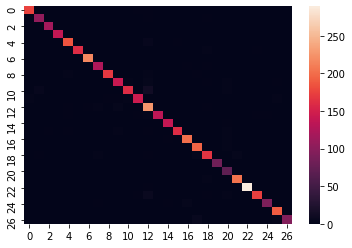

In [109]:
sns.heatmap(cm7)

Confusion matrix, without normalization


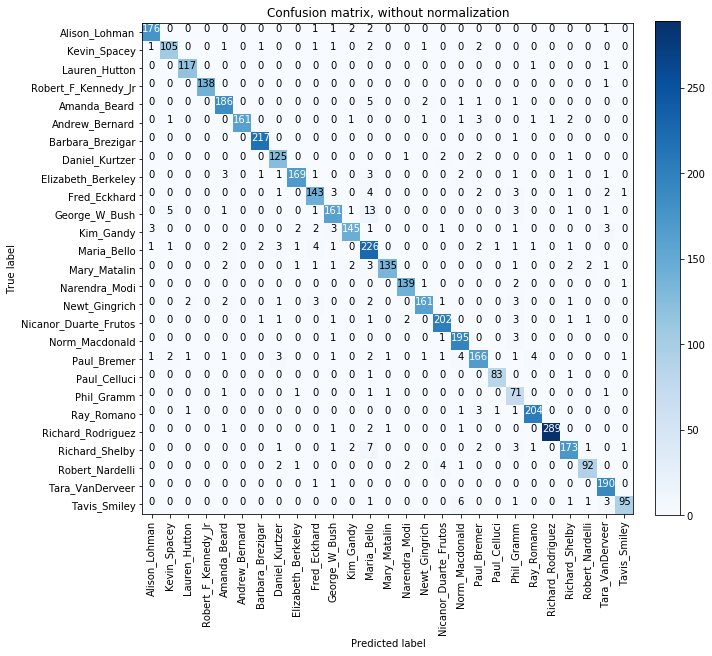

In [110]:
#Make the matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm7, classes = nameList,
                      title='Confusion matrix, without normalization')

In [111]:
print("label precision recall")
for label in range(27):
    print(f"{label:5d} {precision(label, cm7):9.3f} {recall(label, cm7):6.3f}")

label precision recall
    0     0.967  0.962
    1     0.921  0.913
    2     0.967  0.983
    3     1.000  0.993
    4     0.930  0.949
    5     1.000  0.936
    6     0.977  0.995
    7     0.906  0.954
    8     0.966  0.923
    9     0.905  0.894
   10     0.910  0.861
   11     0.948  0.901
   12     0.819  0.915
   13     0.978  0.894
   14     0.965  0.972
   15     0.964  0.915
   16     0.953  0.948
   17     0.920  0.975
   18     0.907  0.874
   19     0.976  0.976
   20     0.710  0.934
   21     0.962  0.967
   22     0.997  0.980
   23     0.930  0.901
   24     0.948  0.902
   25     0.927  0.990
   26     0.960  0.880


In [112]:
print("precision total:", precision_macro_average(cm7))
print("recall total:", recall_macro_average(cm7))

precision total: 0.9375135587212126
recall total: 0.9365371451023857


In [113]:
#Harmonic mean of Precision & Recall, used to indicate a balance between 
#Precision & Recall providing each equal weightage, it ranges from 0 to 1. 
#F1 Score reaches its best value at 1 (perfect precision & recall) and worst at 0.
# https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

f1 = (2*precision_macro_average(cm7)*recall_macro_average(cm7))/(precision_macro_average(cm7) + recall_macro_average(cm7))
print("F1 Score {:0.2f}".format(f1))

F1 Score 0.94


In [114]:
def calcTrueFalse(cm,num_classes):
    
    TruePositive = np.diag(cm)
    
    FalsePositive = []
    for i in range(num_classes):
        FalsePositive.append(sum(cm[:,i]) - cm[i,i])
    
    FalseNegative = []
    for i in range(num_classes):
        FalseNegative.append(sum(cm[i,:]) - cm[i,i])
        
    TrueNegative = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)   # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TrueNegative.append(sum(sum(temp)))      
    
    trueFalse = pd.DataFrame(TruePositive,columns = ['TruePositive'])
    trueFalse['TrueNegative']=TrueNegative
    trueFalse['FalsePositive']=FalsePositive
    trueFalse['FalseNegative']=FalseNegative
    
    return trueFalse

In [115]:
calcTrueFalse(cm7,27)

TruePositive  TrueNegative  FalsePositive  FalseNegative
0            176          4356              6              7
1            105          4421              9             10
2            117          4422              4              2
3            138          4406              0              1
4            186          4335             14             10
5            161          4373              0             11
6            217          4322              5              1
7            125          4401             13              6
8            169          4356              6             14
9            143          4370             15             17
10           161          4342             16             26
11           145          4376              8             16
12           226          4248             50             21
13           135          4391              3             16
14           139          4397              5              4
15           161          4363              6             15
16           202          4322             10             11
17           195          4328             17              5
18           166          4338             17             24
19            83          4458              2              2
20            71          4440             29              5
21           204          4326              8              7
22           289          4249              1              6
23           173          4340             13             19
24            92          4438              5             10
25           190          4338             15              2
26            95          4433              4             13

In [470]:
savedmodel=model7

## Classification 2D

In [80]:
XClass = normalizedShapesTable
y_Class = dfCompare.iloc[:,2].values 
y_Class=y_Class.astype('int')   

In [81]:
print(XClass.shape)
print(y_Class.shape)

(18178, 136)
(18178,)


In [82]:
#Creat new train and test arrays
x_columns=136

XclassDF = pd.DataFrame(XClass)
XclassDF.head()
XclassDF.shape

(18178, 136)

In [83]:
X_Class = XclassDF.iloc[:,0:x_columns].values

In [84]:
X_trainClass, X_testClass, y_trainClass, y_testClass = train_test_split(X_Class, y_Class, test_size=0.25, random_state=0)

In [85]:
print(X_trainClass.shape)
print(X_testClass.shape)
print(y_trainClass.shape)
print(y_testClass.shape)

(13633, 136)
(4545, 136)
(13633,)
(4545,)


In [86]:
#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [106]:
models=[("LR", LogisticRegression()), ("DTC", DecisionTreeClassifier()), 
        ("KNC", KNeighborsClassifier()), ("SVC", SVC()), ("GNB", GaussianNB()), 
        ("RFC", RandomForestClassifier())]

In [182]:
results=[] 

for name, model in models:
    _model= model #value 1
    print('Working on model:',_model)
    _model.fit(X_trainClass, y_trainClass)
    _prediction=_model.predict(X_testClass) #value 2
    _confusion=(confusion_matrix(y_testClass, _prediction)) #value 3
    _accuracy=(accuracy_score(y_testClass, _prediction)) #value 4
    
    model_details=[_model, _prediction, _confusion, _accuracy]
    
    results.append(model_details)

    

Working on model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Working on model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Working on model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Working on model: SVC(C=1.0, 

0.7361936193619362
0.7271727172717272
0.9460946094609461
0.40594059405940597
0.36655665566556656
0.8807480748074807


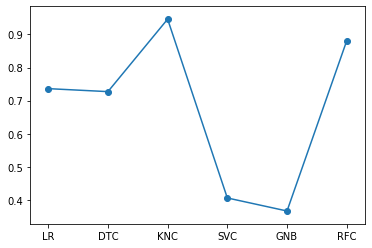

In [227]:
#Plot the results
timer=[]
counter=[]

timer=["LR","DTC","KNC","SVC","GNB","RFC"]
for element in results:
    counter.append(element[3])
    print(element[3])
   
    
plt.plot(timer,counter)
plt.scatter(timer,counter)

plt.show()

## Optimize KNN

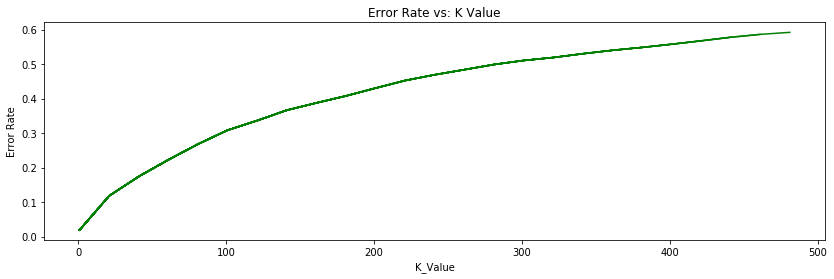

In [272]:
err_rate= []
acc_rate = []
num_neighbours=[]

knnMax = 501

for i in range(1,knnMax,20):
    #print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_trainClass, y_trainClass)
    prediction_i = knn.predict(X_testClass)
    err_rate.append(np.mean(prediction_i != y_testClass))
    
    num_neighbours.append(i)
    acc_rate.append(accuracy_score(y_testClass, prediction_i)) #value 4

Text(0, 0.5, 'Error Rate')

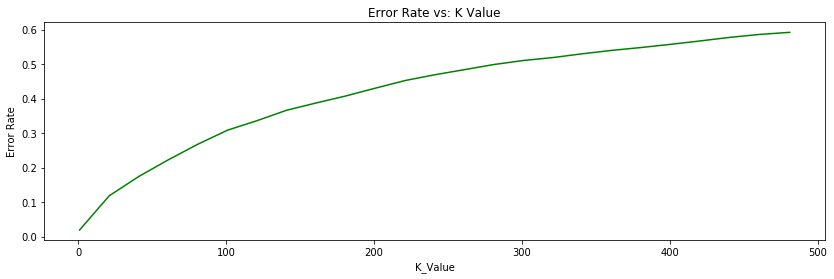

In [273]:
plt.figure(figsize =(14,4))
plt.plot(num_neighbours,err_rate,color = 'green')
plt.title('Error Rate vs: K Value')
plt.xlabel('K_Value')
plt.ylabel('Error Rate')

Text(0, 0.5, 'Accuracy Rate')

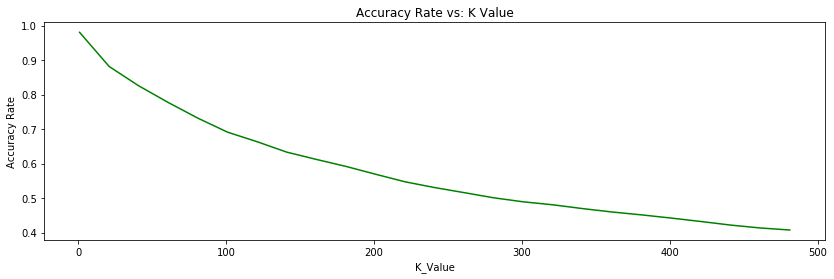

In [275]:
plt.figure(figsize =(14,4))
plt.plot(num_neighbours,acc_rate,color = 'green')
plt.title('Accuracy Rate vs: K Value')
plt.xlabel('K_Value')
plt.ylabel('Accuracy Rate')

In [174]:
# Use the 'optimum' KNN number
modelKNN = KNeighborsClassifier(n_neighbors=1)
    
modelKNN.fit(X_trainClass, y_trainClass)
y_predKNN = modelKNN.predict(X_testClass)
    
#Compare the actual with the output of the predicted model
from sklearn.metrics import confusion_matrix
matrixKNN = confusion_matrix(y_testClass, y_predKNN)



#Need to use other call for the CF
#tn, fp, fn, tp = matrixKNN.ravel()
    
#Calculate the accuracy

0.9808580858085808


In [180]:
scoreKNN=modelKNN.score(X_testClass, y_testClass)
print(scoreKNN)

0.9808580858085808


## Save and display all the Methods for attempting Facial Matching

In [228]:
#Add the best 3D landmark model to the results list
finalScores =counter
methods = timer
print(counter)

[0.7361936193619362, 0.7271727172717272, 0.9460946094609461, 0.40594059405940597, 0.36655665566556656, 0.8807480748074807]


In [229]:
finalScores.append(accuracyCluster)
finalScores.append(accuracy6)
finalScores.append(accuracy7)
methods.append('Clustering')
methods.append('ANN_2D')
methods.append('ANN_3D')


In [230]:
finalScores[2]=scoreKNN

In [231]:
print(finalScores)
print(methods)

[0.7361936193619362, 0.7271727172717272, 0.9808580858085808, 0.40594059405940597, 0.36655665566556656, 0.8807480748074807, 0.07091337028319794, 0.995, 0.996]
['LR', 'DTC', 'KNC', 'SVC', 'GNB', 'RFC', 'Clustering', 'ANN_2D', 'ANN_3D']


Text(0.5, 1.0, 'Comparision of Machine Learning Classification Methods on "Small" Dataset')

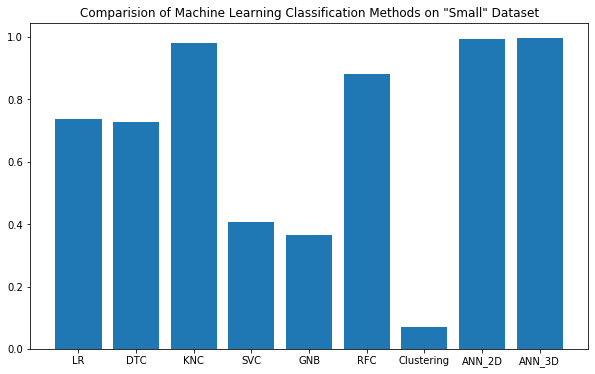

In [232]:
plt.figure(figsize=(10,6))
plt.bar(methods,finalScores)

plt.title('Comparision of Machine Learning Classification Methods on "Small" Dataset')

In [167]:
resultsDf = pd.DataFrame(columns=['Method','Score'])

In [168]:
resultsDf['Method'] = methods
resultsDf['Score'] = finalScores

In [169]:
resultsDf

Method     Score
0      LR  0.736194
1     DTC  0.727613
2     KNC  0.946095
3     SVC  0.405941
4     GNB  0.366557
5     RFC  0.875028
6  ANN_2D  0.995000
7  ANN_3D  0.996000

In [157]:
#Save the results to a .csv file
export_csv = resultsDf.to_csv (r'C:\Users\woodl\OneDrive\Documents\RoboGarden\Final Project\YouTube Faces\resultsDf_27.csv', index = None, header=True)

NameError: name 'resultsDF' is not defined